In [1]:
from datetime import datetime

import librosa.display
import os
import librosa
import numpy as np
from sklearn.model_selection import train_test_split
import random


# 1. 資料加載與標記

In [2]:
def load_segmented_files(directory, target_sr=48000):
    wav_files = []
    leak_wav_files = []
    for dir in os.listdir(directory):
        if not os.path.isdir(os.path.join(directory, dir)):
            continue
        for file in os.listdir(os.path.join(directory, dir)):
            if not file.endswith(".wav"):
                continue
            file_path = os.path.join(directory, dir, file)
            y, sr = librosa.load(file_path, sr=None)
            if sr != target_sr:
                    y = librosa.resample(y, orig_sr=sr, target_sr=target_sr)
            filename = f'{dir}_{file}'
            if 'no-leak' in dir:
                wav_files.append((y, target_sr, filename))
            if 'leak' in dir:
                leak_wav_files.append((y, target_sr, filename))
    print(f"共有 {len(wav_files) + len(leak_wav_files)} 個 wav 檔案，其中 {len(leak_wav_files)} 個有泄漏，{len(wav_files)} 個沒有泄漏")
    return wav_files, leak_wav_files 

# 比較數量，均衡資料
def shuffle_data(wav_files, leak_wav_files):
    wav_files = random.sample(wav_files, int(len(wav_files) * 0.8))
    leak_wav_files = random.sample(leak_wav_files, int(len(leak_wav_files) * 0.8))
    
    return wav_files, leak_wav_files


def create_dataset(directory):
    wav_files, leak_wav_files = load_segmented_files(directory)
    
    # 將資料轉為 NumPy 格式
    X = []
    y = []
    
    for audio, sr, filename in wav_files:
        X.append((audio, sr))
        y.append(0)  # wav_files 標記為 0
    
    for audio, sr, filename in leak_wav_files:
        X.append((audio, sr))
        y.append(1)  # leak_wav_files 標記為 1
    
    return np.array(X, dtype=object), np.array(y)


# 2. 特徵提取與資料預處理

In [3]:
from tqdm import tqdm
from data_preprocess import extract_features, extract_stft_features

def preprocess_data(X, desired_time=2.0, n_mels=128, n_fft=2048, hop_length=512):
    features = []
    for audio, sr in tqdm(X):
        feature = extract_stft_features(audio, sr, desired_time=desired_time, n_fft=n_fft, hop_length=hop_length)
        # feature = extract_features(audio, sr, desired_time=desired_time, n_mels=n_mels, n_fft=n_fft, hop_length=hop_length)
        features.append(feature)
    return np.array(features)


In [4]:
def create_training_data(X,y, desired_time=2.0,  n_mels=256, n_fft=2048, hop_length=512):
    
    print(f"總樣本數: {len(X)}")
    print(f"標籤分佈: {np.bincount(y)}")
    
    
    X_features = preprocess_data(X, desired_time=desired_time, n_mels= n_mels, n_fft=n_fft, hop_length=hop_length)
    
    print(f"特徵形狀: {X_features.shape}")  # 預期形狀: (樣本數, max_len, n_mels)
    
    # 正規化特徵
    X_features = (X_features - np.mean(X_features)) / np.std(X_features)
    
    # 擴展維度以符合 CNN 輸入 (樣本數, 高, 寬, 通道)
    X_features = np.expand_dims(X_features, -1)  # 新形狀: (樣本數, max_len, n_mels, 1)
    
    # 分割訓練集與測試集
    X_train, X_test, y_train, y_test = train_test_split(X_features, y, test_size=0.2)
    
    print(f"訓練集形狀: {X_train.shape}")
    print(f"測試集形狀: {X_test.shape}")
    
    return X_train, X_test, y_train, y_test

In [18]:
X, y = create_dataset('training_data')

共有 17028 個 wav 檔案，其中 8686 個有泄漏，8342 個沒有泄漏


In [22]:
X_train, X_test, y_train, y_test = create_training_data(X, y, desired_time=2.0, n_mels=128, n_fft=512, hop_length=1024)

總樣本數: 17028
標籤分佈: [8342 8686]


100%|██████████| 17028/17028 [00:54<00:00, 314.20it/s]


特徵形狀: (17028, 96, 257)
訓練集形狀: (13622, 96, 257, 1)
測試集形狀: (3406, 96, 257, 1)


# 3. 建立 CNN 模型

In [23]:
from keras.layers import BatchNormalization
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

def create_cnn_model(input_shape):
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    
    input_img = tf.keras.layers.Input(shape=input_shape)
 
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Dropout(0.2)(x)
    
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Dropout(0.2)(x)
    
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Dropout(0.2)(x)
    
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Dropout(0.2)(x)

    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(32, activation='relu')(x)
    x = Dense(16, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(1, activation='sigmoid')(x)
    
    model = tf.keras.Model(inputs=input_img, outputs=x)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    # model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [24]:
def create_model(mockup_input):    
    # 建立模型
    input_shape = (mockup_input.shape[1], mockup_input.shape[2], 1)
    print(f"模型輸入形狀: {input_shape}")
    model = create_cnn_model(input_shape)
    model.summary()
    return model

# 4. 訓練模型

In [25]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau


def train_model(model, X_train, X_test, y_train, y_test, epochs=30, batch_size=32):
        # 訓練模型
        
    # early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        
    history = model.fit(   
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_test, y_test),
        shuffle=True,
        # callbacks=[early_stopping],
        verbose=2
    )
    
    # 評估模型
    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    print(f"Test loss: {test_loss:.4f}")
    print(f"Test accuracy: {test_accuracy:.2f}")
    
    return model, history

In [26]:
def evaluate_model(model, X_test, y_test):
    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    print(f"Test loss: {test_loss:.4f}")
    print(f"Test accuracy: {test_accuracy:.2f}")

In [27]:
cnn_model = create_model(X_train)

模型輸入形狀: (96, 257, 1)
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 96, 257, 1)]      0         
                                                                 
 conv2d_12 (Conv2D)          (None, 96, 257, 16)       160       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 48, 129, 16)      0         
 g2D)                                                            
                                                                 
 dropout_15 (Dropout)        (None, 48, 129, 16)       0         
                                                                 
 conv2d_13 (Conv2D)          (None, 48, 129, 32)       4640      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 24, 65, 32)       0         
 g2D)                                 

In [ ]:
model, history = train_model(cnn_model, X_train, X_test, y_train, y_test, epochs=60, batch_size=8)

Epoch 1/60
426/426 - 6s - loss: 0.6941 - accuracy: 0.5015 - val_loss: 0.6930 - val_accuracy: 0.5076 - 6s/epoch - 14ms/step
Epoch 2/60
426/426 - 3s - loss: 0.6930 - accuracy: 0.5067 - val_loss: 0.6930 - val_accuracy: 0.5120 - 3s/epoch - 8ms/step
Epoch 3/60
426/426 - 3s - loss: 0.6931 - accuracy: 0.5106 - val_loss: 0.6930 - val_accuracy: 0.5076 - 3s/epoch - 8ms/step
Epoch 4/60
426/426 - 3s - loss: 0.6931 - accuracy: 0.5076 - val_loss: 0.6931 - val_accuracy: 0.5076 - 3s/epoch - 8ms/step
Epoch 5/60


In [13]:
evaluate_model(cnn_model, X_test, y_test)

109/109 [==============================] - 0s 3ms/step - loss: 0.6919 - accuracy: 0.5280
Test loss: 0.6919
Test accuracy: 0.53


In [14]:
date = datetime.now().strftime('%Y%m%d%H%M')
model.save(f'model_{date}.h5')
print(f"Model saved as model_{date}.h5")

Model saved as model_202411070056.h5


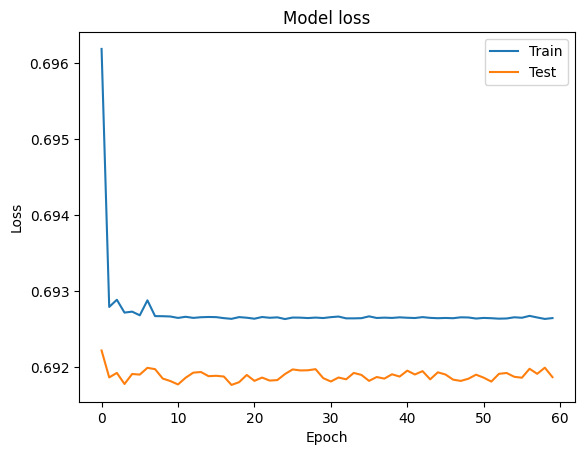

In [15]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.savefig(f'model_loss_{date}.png')
plt.show()